In [ ]:
# Setup
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.io import decode_image
from torchvision.transforms.v2.functional import to_dtype, resize
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import random_split
from torch import nn
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import os, json
import random
import cv2

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/Computer Vision/FungiDataset'
!ls

Mounted at /content/drive
/content/drive/MyDrive/Computer Vision/FungiDataset
 BenchmarkPhotos			 MushroomPCALDA.ipynb
 cnn_weights				 Plotting_DINO_VIT_Results.ipynb
 cnn_weights_pytorch			 train_val_annotations
'Copy of vit_mushroom_dino_3.ipynb'	 Untitled0.ipynb
 dataset				 ViT_draft_files
 dataset_processing			 vit_mushroom_dino_3.ipynb
 MushroomCNN_Resnet18.ipynb		 ViT_weights
 MushroomCNN_Resnet50_tensorflow.ipynb


In [ ]:
# Preprocess and build dataset

labelsToInt = {"e": 0, "p": 1}

class MushroomDataset(Dataset):
    def __init__(self, paths, labels):
        self.img_paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = decode_image(self.img_paths[idx], "RGB")
        image = to_dtype(image, scale= True) # to float
        image = resize(image, (224, 224)) # resize image to right dimension for resnet18
        label = self.labels[idx]
        return image, label

def random_sample(dataset, maxSize):
    random_indices = random.sample(range(len(dataset)), min(len(dataset), maxSize))
    return Subset(dataset, random_indices)

def build_dataset(datasetType, maxSize=None):
    with open(f'train_val_annotations/labels-{datasetType}.json') as srcF:
        # Load the JSON data into a Python list
        fileLabels = json.load(srcF)
    paths = []
    labels = []
    for label in fileLabels:
        paths.append(label['file_name'])
        labels.append(labelsToInt[label['label']])

    dataset = MushroomDataset(paths, labels)

    # Random sample dataset for dev
    if maxSize is not None:
        dataset = random_sample(dataset, maxSize)
    return dataset

train_dataset = build_dataset('train')
val_dataset = build_dataset('val')

In [ ]:
# Build dataloaders
batch_size = 128
num_workers = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers= num_workers, pin_memory= True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers= num_workers, pin_memory= True)

train_dataloader, val_dataloader

In [ ]:
# Function to build ResNet18 base model + custom classificaiton layers
def create_model(weights):
    base_model = models.resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)

    # print(base_model)

    # replace the final layer with our own classification nn
    base_model = nn.Sequential(
        *list(base_model.children())[:-1]
    )
    # print(base_model)
    base_model.requires_grad_(True)

    model = nn.Sequential(
        base_model,
        nn.Flatten(),
        nn.BatchNorm1d(num_features= 512), # input size after flattening
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(32, 1),
        nn.Dropout(0.1),
        nn.Sigmoid()
    )
    return model

model = create_model(None)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

In [ ]:
# Setup for training

def trainEpoch(model, dataloader, criterion, optimizer, scheduler, noGrad=False):
    length = len(dataloader.dataset)
    running_loss = 0.0
    total_loss = 0.0
    total_accuracy = 0.0

    for i, data in enumerate(tqdm(dataloader)):
        train_features, train_labels = data # batch data
        if torch.cuda.is_available():
            train_features, train_labels = train_features.cuda(), \
                train_labels.type(torch.FloatTensor).unsqueeze(1).cuda() # unsqueeze to match outputs size of [B,1] where B is batch size

        if noGrad:
            with torch.no_grad():
                outputs = model(train_features)
                loss = criterion(outputs, train_labels)
        else:
            # forward, backward, optimize
            optimizer.zero_grad()
            outputs = model(train_features)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item()
        if i % 2000 == 1999 and not noGrad:    # print every 2000 mini-batches when training on training data
            tqdm.write(f'[batch {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        # _, predicted = torch.max(outputs, 1)    # output is array of [x, y] where x and y are confidence in class 0 and 1 (doesn't add up to 1)
        # total_accuracy += (predicted == train_labels).sum().item() # take max of x and y as the predicted label
        predicted = outputs > 0.5
        total_accuracy += (predicted == train_labels).sum().item()
        total_loss += loss.item()

    # For scheduler like plateau scheduler
    # if scheduler is not None:
    #     scheduler.step(total_loss)
    return total_accuracy / length, total_loss / length

def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
    }, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    startEpoch = checkpoint['epoch']
    return startEpoch

# Weighted loss
# In training, 17727 poisonous (1), 32576 edible (0), 50,303 total
# In validation, 681 poisonous, 1092 edible
# class_weights = [1 - (32576 / 50303), 1 - (17727 / 50303)]
# class_weights = torch.tensor([32576 / 50303]).cuda()
# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights) # positive class = poisonous
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-6)
scheduler = lr_scheduler.StepLR(optimizer, 5) #lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

In [ ]:
# load checkpoint if needed
startEpoch = 10
checkpoint_path = f"/content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/candidate run 1/weight_train_ep{startEpoch}.pt"
startEpoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
print(f"Loading checkpoint of epoch {startEpoch} from {checkpoint_path}")

<ipython-input-12-37492fa5a92b>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Loading checkpoint of epoch 10 from /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/candidate run 1/weight_train_ep10.pt


In [ ]:
numEpochs = 10
saveCheckpoint = True
# saveCheckpoint = False

if 'startEpoch' not in locals():
    startEpoch = 0

test_accuracies, test_losses, val_accuracies, val_losses = [], [], [], []

for epoch in range(startEpoch, startEpoch+numEpochs):
    print(f'Epoch: {epoch + 1}')

    model.train()
    accuracy, loss = trainEpoch(model, train_dataloader, criterion, optimizer, scheduler)
    print(f'Training Accuracy: {accuracy:.4%}, Loss: {loss:.4%}')

    test_accuracies.append(accuracy)
    test_losses.append(loss)

    if saveCheckpoint:
        checkpoint_path = f"/content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep{epoch+1}.pt"
        save_checkpoint(checkpoint_path, epoch+1, model, optimizer, scheduler)
        print("Saved checkpoint to " + checkpoint_path)

    # Validation
    model.eval()
    accuracy, loss = trainEpoch(model, val_dataloader, criterion, optimizer, scheduler, True)
    print(f'Validation Accuracy: {accuracy:.4%}, Loss: {loss:.4%}')
    val_accuracies.append(accuracy)
    val_losses.append(loss)


    # For step scheduler
    if scheduler is not None:
        scheduler.step(epoch)

print(test_accuracies)
print(test_losses)
print(val_accuracies)
print(val_losses)

In [ ]:
# Validation
model.eval()
accuracy, loss = trainEpoch(model, val_dataloader, criterion, optimizer, scheduler, True)
print(f'Validation Accuracy: {accuracy:.2%}, Loss: {loss:.2%}')

In [ ]:
# Benchmark (small)
fungiBenchmark= 'BenchmarkPhotos'
image_paths = [
    'chanterelle(double_edible_1).jpg',
    'jack_o_lantern(double_poisonous_1).jpg',
    'morel(double_edible_2).jpg',
    'false_morel(double_poisonous_2).jpg',
    'shaggy_mane(double_edible_3).jpg',
    'green_spored_parasol(double_poisonous_3).jpg'
]

def load_images(image_paths):
    images = []
    for path in image_paths:
        path = os.path.join(fungiBenchmark, path)
        image = cv2.imread(path)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, code=cv2.COLOR_BGR2RGB)
        tensor = torch.from_numpy(image)
        tensor = tensor.permute(2, 0, 1) # Permute the dimensions to match PyTorch's format (C, H, W)
        tensor = tensor.float() / 255.0
        tensor = tensor.to(device) # go to GPU
        images.append(tensor)
    images = torch.stack(images)
    return images

images = load_images(image_paths)

model.eval()
with torch.no_grad():
    outputs = model(images)
    predicted = outputs > 0.5
    print(predicted)

tensor([[False],
        [False],
        [False],
        [ True],
        [False],
        [False]], device='cuda:0')


In [ ]:
# Run model on test set
test_path = 'dataset/test'
onlyfiles_paths = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

class MushroomTestDataset(Dataset):
    def __init__(self, paths):
        self.img_paths = paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = decode_image(test_path+'/'+self.img_paths[idx], "RGB")
        image = to_dtype(image, scale= True) # to float
        image = resize(image, (224, 224)) # resize image to right dimension for resnet18
        return image

test_dataset = MushroomTestDataset(onlyfiles_paths)
# test_dataset = random_sample(test_dataset, 30)
test_dataloader = DataLoader(test_dataset, batch_size= 16, num_workers= 2, pin_memory= True)

predictions = []
model.eval()
for data in tqdm(test_dataloader):
    with torch.no_grad():
        outputs = model(data.cuda())
        predicted = outputs > 0.5
        predictions.extend(predicted.tolist())

predictions = torch.tensor(predictions)
print('\n')
print(str((predictions.flatten() == True).sum().item()) + ' / ' + str(len(predictions)))

# Outputs

Training:
```
Epoch: 1
100%|██████████| 393/393 [03:12<00:00,  2.04it/s]
Training Accuracy: 65.9543%, Loss: 0.4856%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep1.pt
100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
Validation Accuracy: 65.1438%, Loss: 0.4939%
Epoch: 2
100%|██████████| 393/393 [03:10<00:00,  2.06it/s]
Training Accuracy: 72.9499%, Loss: 0.4211%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep2.pt
100%|██████████| 14/14 [00:08<00:00,  1.71it/s]
Validation Accuracy: 66.4411%, Loss: 0.5080%
Epoch: 3
100%|██████████| 393/393 [03:12<00:00,  2.04it/s]
Training Accuracy: 81.1144%, Loss: 0.3233%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep3.pt
100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
Validation Accuracy: 65.4822%, Loss: 0.5440%
Epoch: 4
100%|██████████| 393/393 [03:11<00:00,  2.06it/s]
Training Accuracy: 88.6846%, Loss: 0.2062%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep4.pt
100%|██████████| 14/14 [00:08<00:00,  1.62it/s]
Validation Accuracy: 61.8161%, Loss: 0.6989%
Epoch: 5
100%|██████████| 393/393 [03:09<00:00,  2.07it/s]
Training Accuracy: 92.1496%, Loss: 0.1432%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep5.pt
100%|██████████| 14/14 [00:08<00:00,  1.74it/s]
Validation Accuracy: 65.5386%, Loss: 0.9055%
Epoch: 6
100%|██████████| 393/393 [03:10<00:00,  2.06it/s]
Training Accuracy: 93.8453%, Loss: 0.1123%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep6.pt
100%|██████████| 14/14 [00:08<00:00,  1.61it/s]
Validation Accuracy: 64.6926%, Loss: 0.9359%
Epoch: 7
100%|██████████| 393/393 [03:07<00:00,  2.10it/s]
Training Accuracy: 95.6086%, Loss: 0.0761%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep7.pt
100%|██████████| 14/14 [00:08<00:00,  1.68it/s]
Validation Accuracy: 65.5386%, Loss: 0.9326%
Epoch: 8
100%|██████████| 393/393 [03:08<00:00,  2.09it/s]
Training Accuracy: 96.2945%, Loss: 0.0637%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep8.pt
100%|██████████| 14/14 [00:09<00:00,  1.52it/s]
Validation Accuracy: 65.2002%, Loss: 1.0055%
Epoch: 9
100%|██████████| 393/393 [03:15<00:00,  2.02it/s]
Training Accuracy: 96.4197%, Loss: 0.0591%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep9.pt
100%|██████████| 14/14 [00:08<00:00,  1.69it/s]
Validation Accuracy: 65.3130%, Loss: 1.0641%
Epoch: 10
100%|██████████| 393/393 [03:13<00:00,  2.03it/s]
Training Accuracy: 96.3123%, Loss: 0.0588%
Saved checkpoint to /content/drive/MyDrive/Computer Vision/FungiDataset/cnn_weights_pytorch/weight_train_ep10.pt
100%|██████████| 14/14 [00:08<00:00,  1.60it/s]Validation Accuracy: 65.6514%, Loss: 1.1062%
```

Benchmark photos:
```
tensor([[False],
        [False],
        [False],
        [ True],
        [False],
        [False]], device='cuda:0')
```

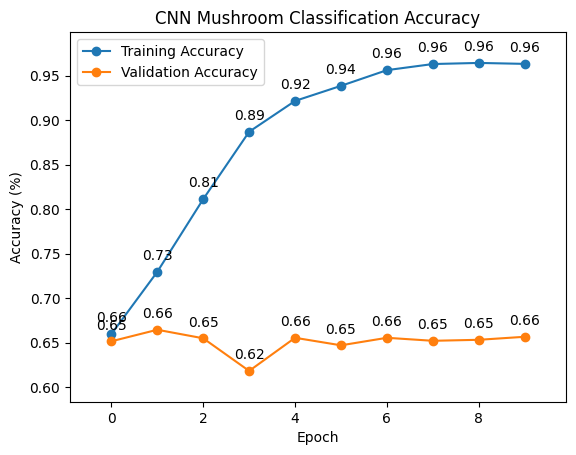

In [ ]:
# Candidate run plotting, code by Mikayla Krech
import matplotlib.pyplot as plt
train_accuracies = [0.659543, 0.729499, 0.811144, 0.886846, 0.921496, 0.938453, 0.956086, 0.962945, 0.964197, 0.963123]
val_accuracies = [0.651438, 0.664411, 0.654822, 0.618161, 0.655386, 0.646926, 0.655386, 0.652002, 0.653130, 0.656514]

plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.title('CNN Mushroom Classification Accuracy') # Add this line

# Add data labels above each point
for x, y in enumerate(train_accuracies):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', va='bottom')  # Adjust 0.5 for vertical offset

for x, y in enumerate(val_accuracies):
    plt.text(x, y + 0.01, f'{y:.2f}', ha='center', va='bottom')  # Adjust 0.5 for vertical offset

# data labels were being cut off so I adjusted it:
plt.margins(x=0.1, y=0.1)

plt.show()